In [182]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../Code/')
from testWN import testWN as twm
from surrogate_model_training_data import get_data

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [183]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [184]:
from surrogate_model_training_data import get_data

# Get network informations

In [185]:
inp_file = '../Code/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())

node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

# Data Pre-Processing

Get clusters:

In [186]:
cluster_labels = pd.read_json('cluster_labels_dt1h.json')
pressure_factor = pd.read_json('pressure_factor_dt1h.json')
n_clusters = 30

Get results:

In [187]:
file = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_1hourSampling/results_sim_14.pkl'
with open(file, 'rb') as f:
    results = pickle.load(f)

## Physical preprocessing:

### Junctions
Scale pressure for each node (similar to clustering)

In [188]:
junction_pressure_scaled = results.node['pressure'][node_names[2]]/pressure_factor.to_numpy()

In [189]:
jun_cl_press = junction_pressure_scaled.groupby(cluster_labels.loc['pressure_cluster'], axis=1)
jun_cl_press_mean = jun_cl_press.mean()
jun_cl_press_std = jun_cl_press.std()

jun_cl_demand = results.node['demand'][node_names[2]].groupby(cluster_labels.loc['pressure_cluster'], axis=1)
jun_cl_demand_sum = jun_cl_demand.sum()

jun_cl_qual = results.node['quality'][node_names[2]].diff(axis=0).groupby(cluster_labels.loc['quality'], axis=1)
qual_cl_qual_mean = jun_cl_qual.mean()
qual_cl_qual_std = jun_cl_qual.std()

<IPython.core.display.Javascript object>


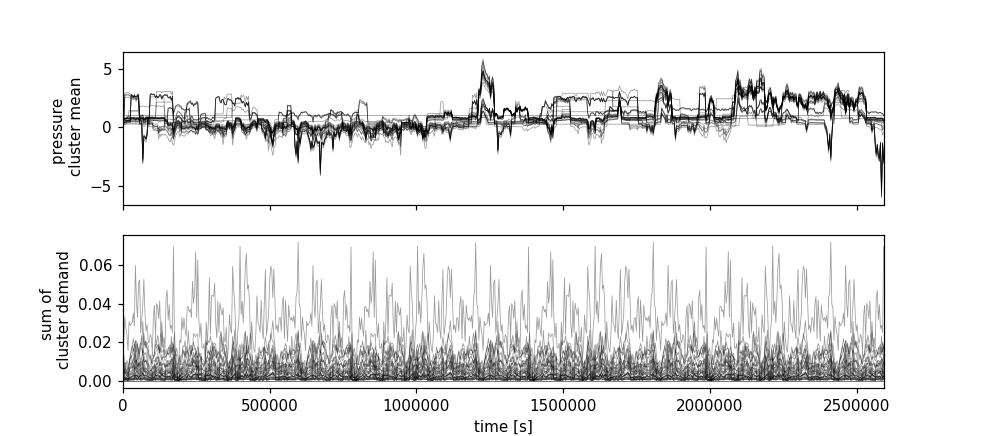

In [190]:
fig, ax = plt.subplots(2,1,figsize=(9,4), sharex=True)
jun_cl_press_mean.plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
ax[0].set_ylabel('pressure \n cluster mean')


jun_cl_demand_sum.plot(ax=ax[1], legend=False, linewidth=0.5, color='k', alpha=0.4)
ax[1].set_ylabel('sum of \n cluster demand')

ax[1].set_xlabel('time [s]')
plt.show()

### Tanks

In [191]:
tank_press = results.node['pressure'][node_names[0]]
# Subtract tank elevation from tank head to obtain tank_level
tank_level = results.node['head'][node_names[0]]-nw_node_df[node_names[0]].loc['elevation']

tank_qual = results.node['quality'][node_names[0]]

<IPython.core.display.Javascript object>


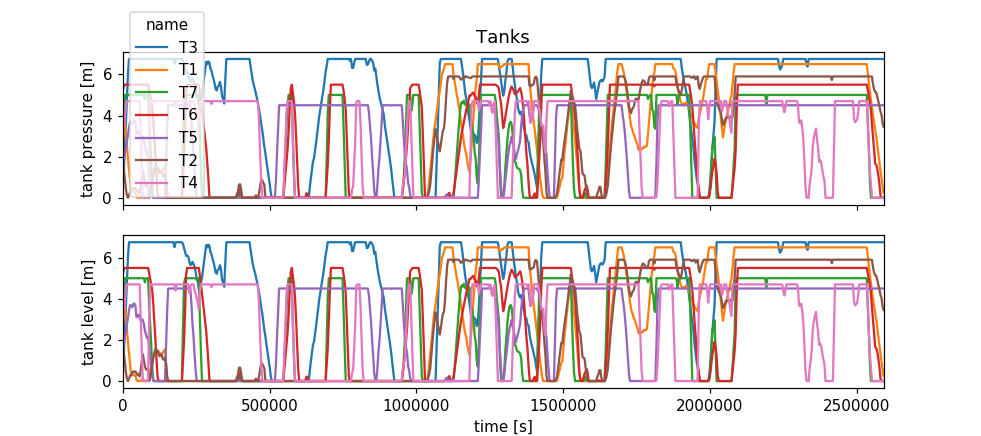

Text(0.5, 0, 'time [s]')

In [192]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(9,4))
tank_press.plot(ax=ax[0])
ax[0].set_title('Tanks')
ax[0].set_ylabel('tank pressure [m]')
tank_level.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('tank level [m]')
ax[1].set_xlabel('time [s]')

### Reservoirs

In [193]:
reservoir_press = results.node['pressure'][node_names[1]]
reservoir_level = results.node['head'][node_names[1]]-nw_node_df[node_names[1]].loc['elevation']

reservoir_qual = results.node['quality'][node_names[1]]

<IPython.core.display.Javascript object>


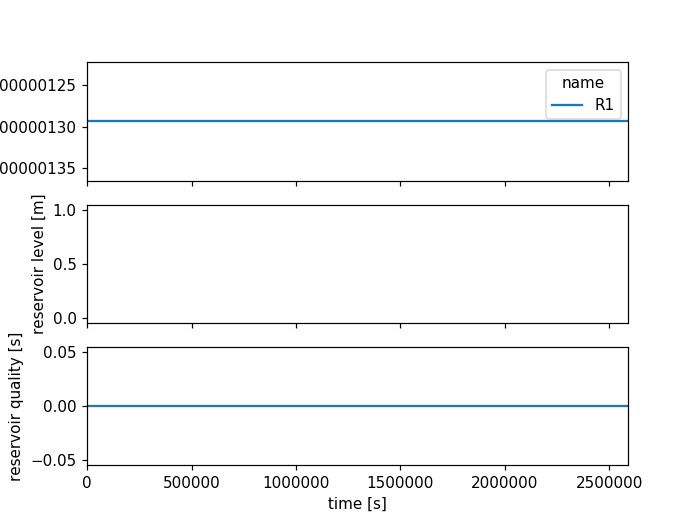

Text(0.5, 0, 'time [s]')

In [194]:
fig, ax = plt.subplots(3,1, sharex=True,)
reservoir_press.plot(ax=ax[0])
ax[0].set_ylabel('reservoir pressure [m]')
reservoir_level.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('reservoir level [m]')
reservoir_qual.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('reservoir quality [s]')
ax[2].set_xlabel('time [s]')

### Pumps

In [195]:
head_pump_speed = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['link_type'] == 'Pump']]
head_pump_status = results.link['status'][nw_link_df.keys()[nw_link_df.loc['link_type'] == 'Pump']]

head_pump_speed_corr = head_pump_speed*head_pump_status

<IPython.core.display.Javascript object>


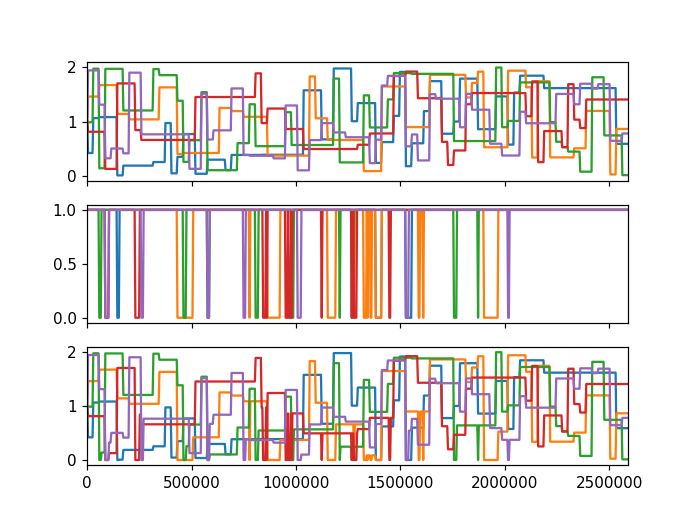

In [196]:
fig, ax = plt.subplots(3,1, sharex=True)
head_pump_speed.plot(ax=ax[0],legend=False)
head_pump_status.plot(ax=ax[1],legend=False)
head_pump_speed_corr.plot(ax=ax[2],legend=False)

In [197]:
pump_energy = economics.pump_energy(results.link['flowrate'], results.node['head'], ctown.wn)[link_names[0]]
pump_energy /= 1000
pump_energy.head(3)

,PU2,PU5,PU6,PU8,PU10
0,60.017796,30.484322,57.840290,30.485120,20.402326
3600,3.685220,91.692606,55.755904,11.097984,105.717288
7200,3.428007,91.825670,55.518343,15.208877,62.572891


<IPython.core.display.Javascript object>


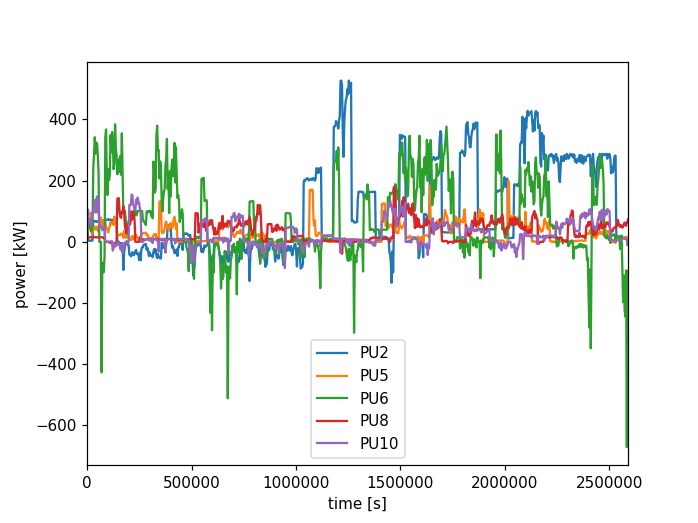

Text(0.5, 0, 'time [s]')

In [198]:
fig, ax = plt.subplots()
pump_energy.plot(ax=ax)
ax.set_ylabel('power [kW]')
ax.set_xlabel('time [s]')

### Valves

In [199]:
PRValve_dp = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'PRV']]
TCValve_throttle = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'TCV']]

PRValve_status = results.link['status'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'PRV']]
TCValve_throttle_status = results.link['status'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'TCV']]

<IPython.core.display.Javascript object>


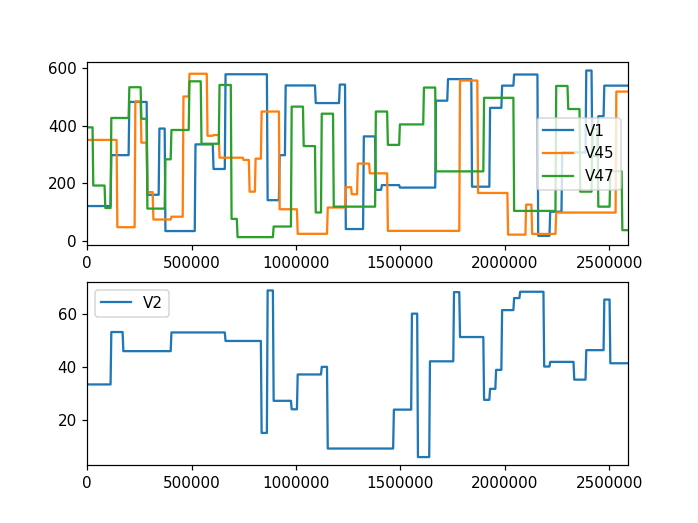

In [200]:
fig, ax = plt.subplots(2)
PRValve_dp.plot(ax=ax[0])
TCValve_throttle.plot(ax=ax[1])

## Neural Network Pre-Processing
### States and Inputs

In [201]:
state_dict = {#'jun_cl_press_mean': jun_cl_press_mean,
              # 'jun_cl_press_std': jun_cl_press_std,
              # 'dqual_cl_press_mean': dqual_cl_press_mean,
              # 'dqual_cl_press_std': dqual_cl_press_std,
              'tank_press': tank_press,
              # 'tank_level': tank_level,
              # 'tank_qual': tank_qual,
              # 'reservoir_press': reservoir_press,
              # 'reservoir_level': reservoir_level,
              # 'reservoir_qual': reservoir_qual,
              }

sys_states = pd.concat(state_dict.values(), axis=1, keys=state_dict.keys())


input_dict = {'head_pump_speed': head_pump_speed_corr,
              'PRValve_dp': PRValve_dp,
              'TCValve_throttle': TCValve_throttle,
              'jun_cl_demand_sum': jun_cl_demand_sum}

sys_inputs = pd.concat(input_dict.values(), axis=1, keys=input_dict.keys())

aux_output_dict = {'pump_energy': pump_energy,
                  'jun_cl_press_mean': jun_cl_press_mean}

aux_outputs = pd.concat(aux_output_dict.values(), axis=1, keys=aux_output_dict.keys())

### Neural Network I/O

Outputs of the neural network.

Note: we are learning the next state of the system and the current aux_outputs (pump energy)

In [202]:
dsys_states = sys_states.diff(axis=0)
dsys_states_next = dsys_states.shift(-1, axis=0)
sys_states_next = sys_states.shift(-1, axis=0)

nn_output_dict = {'sys_states': dsys_states_next,
                 #'sys_states': sys_states_next,
                 'aux_outputs': aux_outputs
                 }
nn_output = pd.concat(nn_output_dict.values(), axis=1, keys=nn_output_dict.keys())

In [203]:
nn_output.head(3)

sys_states                                                              \
     tank_press                                                               
             T3        T1        T7        T6        T5        T2        T4   
0      0.523280 -0.274862  0.350434  0.256515  0.635738 -0.086083 -0.020920   
3600   1.231646 -0.632408  1.389357  0.071549  0.347225 -0.500481  0.388116   
7200   1.219693 -0.629515  0.000000  0.000000  0.164139 -0.499253  0.774827   

     aux_outputs                        ...                              \
     pump_energy                        ... jun_cl_press_mean             
             PU2        PU5        PU6  ...                20        21   
0      60.017796  30.484322  57.840290  ...          0.798365  1.001759   
3600    3.685220  91.692606  55.755904  ...          0.792421  1.007288   
7200    3.428007  91.825670  55.518343  ...          0.731118  1.007321   

                                                                            \
                                                                             
            22        23        24        25        26        27        28   
0     0.778970  0.658361  0.829622  0.494119  0.760277  0.649994  0.671423   
3600  0.673400  0.673437  0.748490  0.273722  0.576104  0.598163  0.701471   
7200  0.739974  0.697531  0.756336  0.521331  0.581449  0.596390  0.732715   

                
                
            29  
0     0.070788  
3600  0.112971  
7200  2.956234  

[3 rows x 42 columns]

Inputs of the neural network:

In [204]:
nn_input_dict = {'sys_states': sys_states,
                 'sys_inputs': sys_inputs}
nn_input = pd.concat(nn_input_dict.values(), axis=1, keys=nn_input_dict.keys(), names=['type', 'name', 'index'])

print('n_samples, n_feat = {}'.format(nn_input.shape))

n_samples, n_feat = (721, 46)


Filter inputs and outputs:

In [205]:
# Filter nan:
output_filter = nn_output.isnull().any(axis=1)
if output_filter.any():
    nn_input = nn_input[~output_filter]
    nn_output = nn_output[~output_filter]

input_filter = nn_input.isnull().any(axis=1)
if input_filter.any():
    nn_input = nn_input[~input_filter]
    nn_output = nn_output[~input_filter]

print('n_samples, n_feat = {}'.format(nn_input.shape))

n_samples, n_feat = (720, 46)


### Compare to external output function:

This function is used to create the complete dataset for training.

In [229]:
file_list = ['/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_1hourSampling/results_sim_14.pkl',
            #'/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/results_sim_15_try.pkl',
            #'/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/results_sim_16_try.pkl',
            #'/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/results_sim_17_try.pkl'
            ]

n_arx = 0
nn_input_ext, nn_output_ext = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False)

In [230]:
nn_output.shape

(720, 42)

In [231]:
similar_inputs=((nn_input_ext-nn_input)==0).all().all()
print('inputs are identical: {}'.format(similar_inputs))

similar_outputs=((nn_output_ext-nn_output)==0).all().all()
print('outputs are identical: {}'.format(similar_outputs))

inputs are identical: True
outputs are identical: True


### Normalize Data:

In [170]:
input_offset = 0*nn_input.mean()
nn_input_offset = nn_input - input_offset

input_scaling = nn_input_offset.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_scaled = nn_input_offset/input_scaling

output_offset = 0*nn_output.mean()
nn_output_offset = nn_output - output_offset

output_scaling = nn_output_offset.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_scaled = nn_output_offset/output_scaling

### Train / Test Splitting

In [171]:
X_train, X_test, Y_train, Y_test = train_test_split(nn_input_scaled, nn_output_scaled, test_size=0.2)

In [172]:
X_train.shape

(576, 46)

# Neural Network

## Create Model

In [48]:
n_layer = 3
n_units = 80
l1_regularizer = 0

model_param = {}
model_param['n_in'] = nn_input.shape[1]
model_param['n_out'] = nn_output.shape[1]
model_param['n_units'] = (n_layer)*[n_units]
model_param['activation'] = (n_layer) * ['tanh']

inputs = keras.Input(shape=(model_param['n_in'],))

layer_list = [inputs]


for i in range(len(model_param['n_units'])-1):
    layer_list.append(
        keras.layers.Dense(model_param['n_units'][i],
                           activation=model_param['activation'][i],
                           kernel_regularizer=keras.regularizers.l1(l=l1_regularizer)
                           )(layer_list[i])
    )

outputs = keras.layers.Dense(model_param['n_out'],
                             activation='linear')(layer_list[-1])

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 46)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 80)                3760      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_4 (Dense)              (None, 42)                3402      
Total params: 13,642
Trainable params: 13,642
Non-trainable params: 0
_________________________________________________________________


## Train model

In [49]:
optim = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-8, patience=50, mode='min')
model.compile(optimizer=optim,
              loss='mse')

In [63]:
history = model.fit(X_train.to_numpy(), 
                    Y_train.to_numpy(), 
                    batch_size=100, 
                    epochs=1000,
                    validation_data=(X_test.to_numpy(),Y_test.to_numpy()),
                    callbacks=[callback])

Train on 576 samples, validate on 144 samples
Epoch 1/1000
576/576 [==============================] - 0s 305us/sample - loss: 0.0015 - val_loss: 0.0035
Epoch 2/1000
576/576 [==============================] - 0s 206us/sample - loss: 0.0014 - val_loss: 0.0034
Epoch 3/1000
576/576 [==============================] - 0s 147us/sample - loss: 0.0015 - val_loss: 0.0036
Epoch 4/1000
576/576 [==============================] - 0s 149us/sample - loss: 0.0015 - val_loss: 0.0034
Epoch 5/1000
576/576 [==============================] - 0s 134us/sample - loss: 0.0014 - val_loss: 0.0034
Epoch 6/1000
576/576 [==============================] - 0s 162us/sample - loss: 0.0014 - val_loss: 0.0034
Epoch 7/1000
576/576 [==============================] - 0s 152us/sample - loss: 0.0014 - val_loss: 0.0034
Epoch 8/1000
576/576 [==============================] - 0s 141us/sample - loss: 0.0014 - val_loss: 0.0034
Epoch 9/1000
576/576 [==============================] - 0s 140us/sample - loss: 0.0014 - val_loss: 0.0034


576/576 [==============================] - 0s 133us/sample - loss: 0.0013 - val_loss: 0.0034
Epoch 78/1000
576/576 [==============================] - 0s 164us/sample - loss: 0.0014 - val_loss: 0.0034
Epoch 79/1000
576/576 [==============================] - 0s 148us/sample - loss: 0.0015 - val_loss: 0.0034
Epoch 80/1000
576/576 [==============================] - 0s 147us/sample - loss: 0.0015 - val_loss: 0.0037
Epoch 81/1000
576/576 [==============================] - 0s 186us/sample - loss: 0.0015 - val_loss: 0.0036
Epoch 82/1000
576/576 [==============================] - 0s 148us/sample - loss: 0.0015 - val_loss: 0.0034
Epoch 83/1000
576/576 [==============================] - 0s 197us/sample - loss: 0.0016 - val_loss: 0.0034
Epoch 84/1000
576/576 [==============================] - 0s 171us/sample - loss: 0.0014 - val_loss: 0.0034
Epoch 85/1000
576/576 [==============================] - 0s 147us/sample - loss: 0.0014 - val_loss: 0.0035
Epoch 86/1000
576/576 [============================

576/576 [==============================] - 0s 124us/sample - loss: 0.0014 - val_loss: 0.0033
Epoch 154/1000
576/576 [==============================] - 0s 105us/sample - loss: 0.0014 - val_loss: 0.0033
Epoch 155/1000
576/576 [==============================] - 0s 118us/sample - loss: 0.0013 - val_loss: 0.0034
Epoch 156/1000
576/576 [==============================] - 0s 108us/sample - loss: 0.0013 - val_loss: 0.0033
Epoch 157/1000
576/576 [==============================] - 0s 126us/sample - loss: 0.0013 - val_loss: 0.0033
Epoch 158/1000
576/576 [==============================] - 0s 108us/sample - loss: 0.0014 - val_loss: 0.0034
Epoch 159/1000
576/576 [==============================] - 0s 126us/sample - loss: 0.0013 - val_loss: 0.0032
Epoch 160/1000
576/576 [==============================] - 0s 108us/sample - loss: 0.0013 - val_loss: 0.0033
Epoch 161/1000
576/576 [==============================] - 0s 110us/sample - loss: 0.0013 - val_loss: 0.0033
Epoch 162/1000
576/576 [===================

Epoch 229/1000
576/576 [==============================] - 0s 189us/sample - loss: 0.0013 - val_loss: 0.0033
Epoch 230/1000
576/576 [==============================] - 0s 144us/sample - loss: 0.0013 - val_loss: 0.0033
Epoch 231/1000
576/576 [==============================] - 0s 124us/sample - loss: 0.0013 - val_loss: 0.0032
Epoch 232/1000
576/576 [==============================] - 0s 109us/sample - loss: 0.0013 - val_loss: 0.0034
Epoch 233/1000
576/576 [==============================] - 0s 121us/sample - loss: 0.0013 - val_loss: 0.0033
Epoch 234/1000
576/576 [==============================] - 0s 106us/sample - loss: 0.0014 - val_loss: 0.0035
Epoch 235/1000
576/576 [==============================] - 0s 119us/sample - loss: 0.0013 - val_loss: 0.0033
Epoch 236/1000
576/576 [==============================] - 0s 103us/sample - loss: 0.0013 - val_loss: 0.0033
Epoch 237/1000
576/576 [==============================] - 0s 107us/sample - loss: 0.0013 - val_loss: 0.0032
Epoch 238/1000
576/576 [====

Epoch 305/1000
576/576 [==============================] - 0s 113us/sample - loss: 0.0012 - val_loss: 0.0032
Epoch 306/1000
576/576 [==============================] - 0s 113us/sample - loss: 0.0012 - val_loss: 0.0032
Epoch 307/1000
576/576 [==============================] - 0s 111us/sample - loss: 0.0012 - val_loss: 0.0033
Epoch 308/1000
576/576 [==============================] - 0s 148us/sample - loss: 0.0012 - val_loss: 0.0032
Epoch 309/1000
576/576 [==============================] - 0s 114us/sample - loss: 0.0012 - val_loss: 0.0032
Epoch 310/1000
576/576 [==============================] - 0s 104us/sample - loss: 0.0012 - val_loss: 0.0032
Epoch 311/1000
576/576 [==============================] - 0s 123us/sample - loss: 0.0012 - val_loss: 0.0032
Epoch 312/1000
576/576 [==============================] - 0s 110us/sample - loss: 0.0012 - val_loss: 0.0032
Epoch 313/1000
576/576 [==============================] - 0s 102us/sample - loss: 0.0012 - val_loss: 0.0032
Epoch 314/1000
576/576 [====

Epoch 381/1000
576/576 [==============================] - 0s 128us/sample - loss: 0.0012 - val_loss: 0.0032
Epoch 382/1000
576/576 [==============================] - 0s 101us/sample - loss: 0.0012 - val_loss: 0.0033
Epoch 383/1000
576/576 [==============================] - 0s 186us/sample - loss: 0.0012 - val_loss: 0.0032
Epoch 384/1000
576/576 [==============================] - 0s 206us/sample - loss: 0.0012 - val_loss: 0.0033
Epoch 385/1000
576/576 [==============================] - 0s 198us/sample - loss: 0.0013 - val_loss: 0.0032
Epoch 386/1000
576/576 [==============================] - 0s 159us/sample - loss: 0.0012 - val_loss: 0.0032
Epoch 387/1000
576/576 [==============================] - 0s 129us/sample - loss: 0.0012 - val_loss: 0.0034
Epoch 388/1000
576/576 [==============================] - 0s 111us/sample - loss: 0.0012 - val_loss: 0.0032
Epoch 389/1000
576/576 [==============================] - 0s 114us/sample - loss: 0.0012 - val_loss: 0.0032
Epoch 390/1000
576/576 [====

Epoch 457/1000
576/576 [==============================] - 0s 168us/sample - loss: 0.0012 - val_loss: 0.0031
Epoch 458/1000
576/576 [==============================] - 0s 300us/sample - loss: 0.0012 - val_loss: 0.0031
Epoch 459/1000
576/576 [==============================] - 0s 205us/sample - loss: 0.0011 - val_loss: 0.0033
Epoch 460/1000
576/576 [==============================] - 0s 160us/sample - loss: 0.0011 - val_loss: 0.0032
Epoch 461/1000
576/576 [==============================] - 0s 157us/sample - loss: 0.0012 - val_loss: 0.0031
Epoch 462/1000
576/576 [==============================] - 0s 192us/sample - loss: 0.0011 - val_loss: 0.0031
Epoch 463/1000
576/576 [==============================] - 0s 353us/sample - loss: 0.0011 - val_loss: 0.0031
Epoch 464/1000
576/576 [==============================] - 0s 331us/sample - loss: 0.0011 - val_loss: 0.0032
Epoch 465/1000
576/576 [==============================] - 0s 241us/sample - loss: 0.0012 - val_loss: 0.0031
Epoch 466/1000
576/576 [====

Epoch 533/1000
576/576 [==============================] - 0s 165us/sample - loss: 0.0011 - val_loss: 0.0031
Epoch 534/1000
576/576 [==============================] - 0s 143us/sample - loss: 0.0011 - val_loss: 0.0030
Epoch 535/1000
576/576 [==============================] - 0s 148us/sample - loss: 0.0011 - val_loss: 0.0030
Epoch 536/1000
576/576 [==============================] - 0s 141us/sample - loss: 0.0011 - val_loss: 0.0031
Epoch 537/1000
576/576 [==============================] - 0s 153us/sample - loss: 0.0011 - val_loss: 0.0031
Epoch 538/1000
576/576 [==============================] - 0s 155us/sample - loss: 0.0011 - val_loss: 0.0031
Epoch 539/1000
576/576 [==============================] - 0s 152us/sample - loss: 0.0011 - val_loss: 0.0031
Epoch 540/1000
576/576 [==============================] - 0s 185us/sample - loss: 0.0011 - val_loss: 0.0031
Epoch 541/1000
576/576 [==============================] - 0s 160us/sample - loss: 0.0011 - val_loss: 0.0031
Epoch 542/1000
576/576 [====

Epoch 609/1000
576/576 [==============================] - 0s 150us/sample - loss: 0.0010 - val_loss: 0.0030
Epoch 610/1000
576/576 [==============================] - 0s 154us/sample - loss: 0.0011 - val_loss: 0.0031
Epoch 611/1000
576/576 [==============================] - 0s 144us/sample - loss: 0.0011 - val_loss: 0.0030
Epoch 612/1000
576/576 [==============================] - 0s 153us/sample - loss: 0.0011 - val_loss: 0.0031
Epoch 613/1000
576/576 [==============================] - 0s 162us/sample - loss: 0.0010 - val_loss: 0.0031
Epoch 614/1000
576/576 [==============================] - 0s 160us/sample - loss: 0.0011 - val_loss: 0.0031
Epoch 615/1000
576/576 [==============================] - 0s 148us/sample - loss: 0.0011 - val_loss: 0.0030
Epoch 616/1000
576/576 [==============================] - 0s 153us/sample - loss: 0.0011 - val_loss: 0.0031
Epoch 617/1000
576/576 [==============================] - 0s 162us/sample - loss: 0.0011 - val_loss: 0.0030
Epoch 618/1000
576/576 [====

Epoch 685/1000
576/576 [==============================] - 0s 119us/sample - loss: 9.9141e-04 - val_loss: 0.0030
Epoch 686/1000
576/576 [==============================] - 0s 105us/sample - loss: 0.0010 - val_loss: 0.0030
Epoch 687/1000
576/576 [==============================] - 0s 107us/sample - loss: 0.0011 - val_loss: 0.0031
Epoch 688/1000
576/576 [==============================] - 0s 120us/sample - loss: 0.0010 - val_loss: 0.0030
Epoch 689/1000
576/576 [==============================] - 0s 111us/sample - loss: 0.0010 - val_loss: 0.0030
Epoch 690/1000
576/576 [==============================] - 0s 112us/sample - loss: 9.9690e-04 - val_loss: 0.0030
Epoch 691/1000
576/576 [==============================] - 0s 110us/sample - loss: 0.0010 - val_loss: 0.0032
Epoch 692/1000
576/576 [==============================] - 0s 114us/sample - loss: 0.0011 - val_loss: 0.0031
Epoch 693/1000
576/576 [==============================] - 0s 106us/sample - loss: 0.0011 - val_loss: 0.0035
Epoch 694/1000
576/5

576/576 [==============================] - 0s 106us/sample - loss: 0.0010 - val_loss: 0.0031
Epoch 761/1000
576/576 [==============================] - 0s 108us/sample - loss: 0.0010 - val_loss: 0.0030
Epoch 762/1000
576/576 [==============================] - 0s 100us/sample - loss: 9.9664e-04 - val_loss: 0.0029
Epoch 763/1000
576/576 [==============================] - 0s 104us/sample - loss: 0.0010 - val_loss: 0.0030
Epoch 764/1000
576/576 [==============================] - 0s 109us/sample - loss: 9.9210e-04 - val_loss: 0.0029
Epoch 765/1000
576/576 [==============================] - 0s 110us/sample - loss: 0.0010 - val_loss: 0.0030
Epoch 766/1000
576/576 [==============================] - 0s 103us/sample - loss: 9.9804e-04 - val_loss: 0.0030
Epoch 767/1000
576/576 [==============================] - 0s 101us/sample - loss: 0.0010 - val_loss: 0.0030
Epoch 768/1000
576/576 [==============================] - 0s 134us/sample - loss: 9.9565e-04 - val_loss: 0.0029
Epoch 769/1000
576/576 [===

Epoch 834/1000
576/576 [==============================] - 0s 117us/sample - loss: 9.9389e-04 - val_loss: 0.0030
Epoch 835/1000
576/576 [==============================] - 0s 115us/sample - loss: 9.9891e-04 - val_loss: 0.0031
Epoch 836/1000
576/576 [==============================] - 0s 117us/sample - loss: 0.0010 - val_loss: 0.0031
Epoch 837/1000
576/576 [==============================] - 0s 113us/sample - loss: 0.0011 - val_loss: 0.0030
Epoch 838/1000
576/576 [==============================] - 0s 114us/sample - loss: 0.0011 - val_loss: 0.0031
Epoch 839/1000
576/576 [==============================] - 0s 113us/sample - loss: 0.0011 - val_loss: 0.0030
Epoch 840/1000
576/576 [==============================] - 0s 116us/sample - loss: 0.0010 - val_loss: 0.0031
Epoch 841/1000
576/576 [==============================] - 0s 112us/sample - loss: 0.0010 - val_loss: 0.0030
Epoch 842/1000
576/576 [==============================] - 0s 112us/sample - loss: 0.0011 - val_loss: 0.0030
Epoch 843/1000
576/5

576/576 [==============================] - 0s 144us/sample - loss: 9.2765e-04 - val_loss: 0.0029
Epoch 909/1000
576/576 [==============================] - 0s 153us/sample - loss: 9.0730e-04 - val_loss: 0.0029
Epoch 910/1000
576/576 [==============================] - 0s 157us/sample - loss: 9.2777e-04 - val_loss: 0.0029
Epoch 911/1000
576/576 [==============================] - 0s 142us/sample - loss: 9.4626e-04 - val_loss: 0.0029
Epoch 912/1000
576/576 [==============================] - 0s 142us/sample - loss: 9.4583e-04 - val_loss: 0.0030
Epoch 913/1000
576/576 [==============================] - 0s 156us/sample - loss: 9.6566e-04 - val_loss: 0.0029
Epoch 914/1000
576/576 [==============================] - 0s 149us/sample - loss: 9.1510e-04 - val_loss: 0.0029
Epoch 915/1000
576/576 [==============================] - 0s 148us/sample - loss: 9.4267e-04 - val_loss: 0.0029
Epoch 916/1000
576/576 [==============================] - 0s 147us/sample - loss: 9.5925e-04 - val_loss: 0.0030
Epoch 9

576/576 [==============================] - 0s 127us/sample - loss: 9.3748e-04 - val_loss: 0.0029
Epoch 982/1000
576/576 [==============================] - 0s 103us/sample - loss: 8.9896e-04 - val_loss: 0.0029
Epoch 983/1000
576/576 [==============================] - 0s 158us/sample - loss: 8.9159e-04 - val_loss: 0.0029
Epoch 984/1000
576/576 [==============================] - 0s 107us/sample - loss: 9.0735e-04 - val_loss: 0.0030
Epoch 985/1000
576/576 [==============================] - 0s 125us/sample - loss: 9.1839e-04 - val_loss: 0.0030
Epoch 986/1000
576/576 [==============================] - 0s 106us/sample - loss: 9.7274e-04 - val_loss: 0.0029
Epoch 987/1000
576/576 [==============================] - 0s 110us/sample - loss: 9.5237e-04 - val_loss: 0.0029
Epoch 988/1000
576/576 [==============================] - 0s 101us/sample - loss: 9.0020e-04 - val_loss: 0.0030
Epoch 989/1000
576/576 [==============================] - 0s 103us/sample - loss: 9.3931e-04 - val_loss: 0.0029
Epoch 9

## Evaluate model

In [173]:
class simulator:
    def __init__(self, model, input_scaling, output_scaling, input_offset, output_offset, x0, t0):
        self.model = model
        
        self.input_scaling = input_scaling.to_numpy().reshape(1,-1)
        self.output_scaling = output_scaling.to_numpy().reshape(1,-1)
        self.input_offset = input_offset.to_numpy().reshape(1,-1)
        self.output_offset = output_offset.to_numpy().reshape(1,-1)
        
        self.x = x0
        self.n_x = x0.shape[1]
        self.aux = []
                
        self.t = np.array([t0]).reshape(-1,1)
        self.dt = 3600
            
    def eval_nn(self):
        # Scale input:
        self.nn_in = np.concatenate((self.x[[-1],:], self.u[[-1],:]),axis=1).reshape(1,-1)
        self.nn_in_scaled = (self.nn_in-self.input_offset)/self.input_scaling
        # Evaluate NN:
        self.nn_out_scaled = self.model.predict(self.nn_in_scaled)
        # Scale output:
        self.nn_out = self.nn_out_scaled*self.output_scaling+self.output_offset
#         x_new = self.nn_out[:,:self.n_x]
        x_new = self.x[[-1],:]+self.nn_out[:,:self.n_x]
        aux_new = self.nn_out[:,self.n_x:]
        self.aux.append(aux_new)
    
        self.x = np.append(self.x, x_new, axis=0)
        self.t = np.append(self.t, np.copy(self.t)[[-1]]+self.dt, axis=0)
        
        
    def next_step(self, sys_inputs_now):
        if 'u' in self.__dict__:
            self.u = np.append(self.u, sys_inputs_now.reshape(1,-1), axis=0)
        else:
            self.u = sys_inputs_now.reshape(1,-1)
        
        self.eval_nn()

In [179]:
x0 = sys_states.head(1).to_numpy()
t0 = sys_states.head(1).index.to_numpy()

nsim = simulator(model, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [180]:
for k in range(100):
    print(k)
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim.next_step(sys_inputs_now)
sim_res = pd.DataFrame(nsim.x, columns=sys_states.columns, index=nsim.t.flatten())
sim_aux = pd.DataFrame(np.concatenate(nsim.aux), columns = aux_outputs.columns,index=nsim.t.flatten()[:-1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


<IPython.core.display.Javascript object>


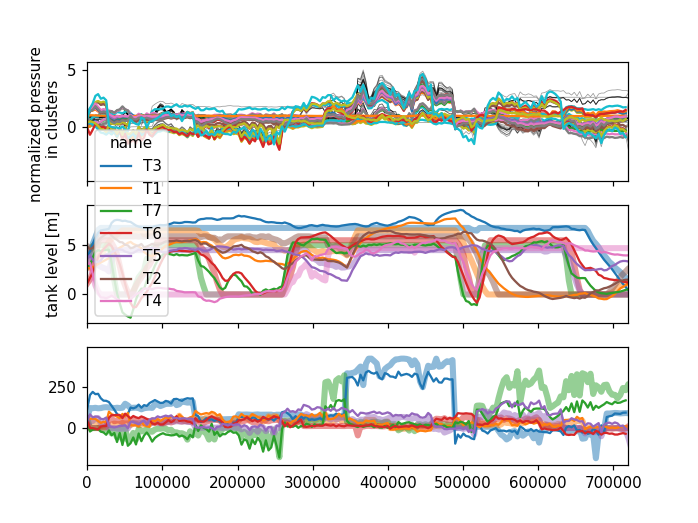

Text(0.5, 0, 'time [s]')

In [181]:
fig, ax = plt.subplots(3,1, sharex=True)

jun_cl_press_mean.plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

tank_press.plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res['tank_press'].plot(ax=ax[1])

pump_energy.plot(ax=ax[2], legend=False, alpha=0.5, linewidth=4)
ax[2].set_prop_cycle(None)
sim_aux['pump_energy'].plot(ax=ax[2], legend=False)

ax[0].set_xlim(0, sim_res.index.max())
ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[1].set_xlabel('time [s]')

# Linear Model

In [44]:
linear_reg = LinearRegression().fit(nn_input_scaled.to_numpy(), nn_output_scaled.to_numpy())

In [45]:
x0 = sys_states.head(1).to_numpy()
t0 = sys_states.head(1).index.to_numpy()

nsim_lin = simulator(linear_reg, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [102]:
for k in range(100):
    print(k)
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim_lin.next_step(sys_inputs_now)
sim_res_lin = pd.DataFrame(nsim_lin.x, columns=sys_states.columns, index=nsim_lin.t.flatten())
sim_aux_lin = pd.DataFrame(np.concatenate(nsim_lin.aux), columns = aux_outputs.columns,index=nsim_lin.t.flatten()[:-1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<IPython.core.display.Javascript object>


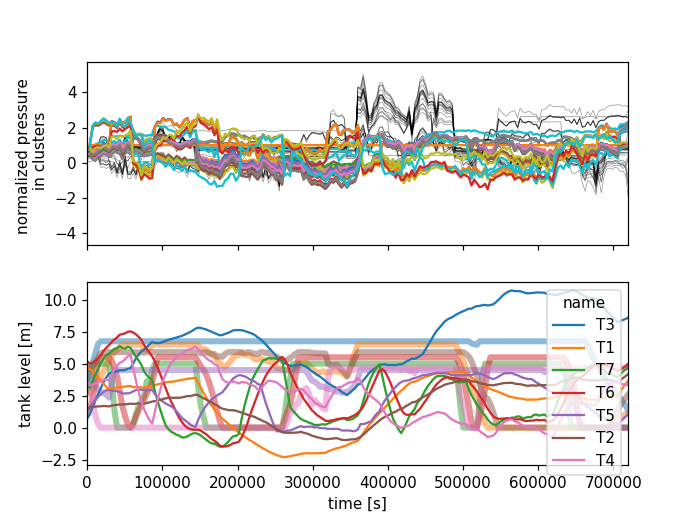

Text(0.5, 0, 'time [s]')

In [105]:
fig, ax = plt.subplots(2,1, sharex=True)

jun_cl_press_mean.plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux_lin['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

tank_press.plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res_lin['tank_press'].plot(ax=ax[1])

ax[0].set_xlim(0, sim_res_lin.index.max())

ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[1].set_xlabel('time [s]')

# Create full training data set:

In [96]:
def scale(X, offset=None, scaling=None, scaling_min=1e-5):
    if np.any(offset) and np.any(scaling):
        X = (X-offset)/scaling
    else:
        offset = X.mean()
        X = X-offset
        scaling = X.abs().max()
        scaling.loc[scaling.abs()<scaling_min] = scaling_min
        X = X/scaling
    return X, offset, scaling

## Load data

In [98]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

In [99]:
nn_input, nn_output = get_data(file_list, 4, cluster_labels, pressure_factor)

In [106]:
X_train, X_test, Y_train, Y_test = train_test_split(nn_input, nn_output, test_size=0.2)

In [107]:
X_train, input_offset, input_scaling = scale(X_train)
X_test, _, _ = scale(X_test, input_offset, input_scaling)

Y_train, output_offset, output_scaling = scale(Y_train)
Y_test, _, _ = scale(Y_test, output_offset, output_scaling)

## Save everything

Pack everything needed for training in a .pkl file:

In [108]:
training_dict = {
    'X_train': X_train,
    'X_test': X_test,
    'Y_train': Y_train,
    'Y_test': Y_test,
    'x_offset': input_offset,
    'x_scaling': input_scaling,
    'y_offset': output_offset,
    'y_scaling': output_scaling,
    'cluster_labels': cluster_labels,
    'pressure_factor': pressure_factor
}

with open('02_training_setup_narx4.pkl', 'wb') as f:
    results = pickle.dump(training_dict, f)

# Test external model:

In [109]:
model_path = './models/'
model_name = '000_model_01'
model_ext = keras.models.load_model(model_path+model_name+'.h5')

with open('./training_data/02_training_setup_narx4.pkl', 'rb') as f:
    train_data = pickle.load(f)
    

In [110]:
model_ext.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 304)]             0         
_________________________________________________________________
dense (Dense)                (None, 70)                21350     
_________________________________________________________________
dense_1 (Dense)              (None, 42)                2982      
Total params: 24,332
Trainable params: 24,332
Non-trainable params: 0
_________________________________________________________________


In [111]:
x_scaling = train_data['x_scaling']
y_scaling = train_data['y_scaling']
x_offset = train_data['x_offset']
y_offset = train_data['y_offset']

n_arx = 4

x0 = sys_states.head(n_arx).to_numpy()
u0 = sys_inputs.head(n_arx-1).to_numpy()
t0 = sys_states.head(n_arx).index.to_numpy()

nsim = narx_simulator(model_ext, n_arx, x_scaling, y_scaling, x_offset, y_offset, x0, u0, t0)

In [112]:
for k in range(100):
    sys_inputs_now = sys_inputs.iloc[n_arx+k].to_numpy()
    nsim.next_step(sys_inputs_now)
sim_res = pd.DataFrame(nsim.x, columns=sys_states.columns, index=nsim.t)

<IPython.core.display.Javascript object>


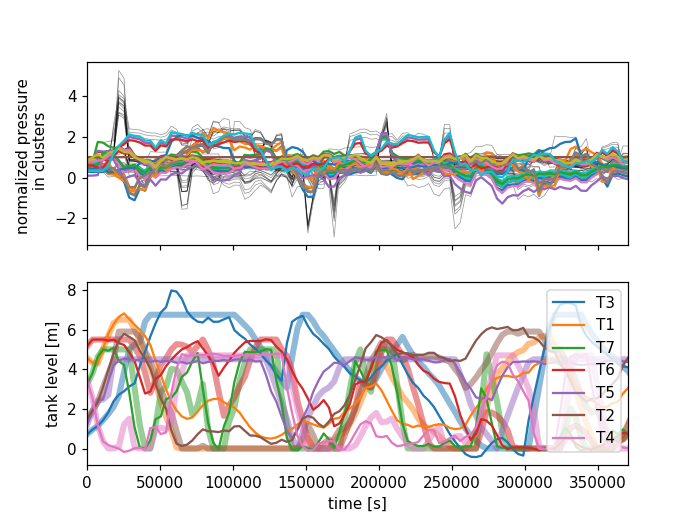

Text(0.5, 0, 'time [s]')

In [113]:
fig, ax = plt.subplots(2,1, sharex=True)

jun_cl_press_mean.plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_res['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

tank_press.plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res['tank_press'].plot(ax=ax[1])

ax[0].set_xlim(0, sim_res.index.max())

ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[1].set_xlabel('time [s]')